## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [ ]:
!pip install pyarrow

In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision.transforms as transforms
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LR = 0.0002
BATCH_SIZE = 8
IMAGE_SIZE = 128
DATA_DIR = "/content/drive/MyDrive/data"
SAVE_DIR = "/content/drive/MyDrive/models"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cpu'

In [ ]:
train_data_names = ["train-00000-of-00008.parquet", "train-00001-of-00008.parquet", "train-00002-of-00008.parquet", "train-00003-of-00008.parquet", "train-00004-of-00008.parquet", "train-00005-of-00008.parquet", "train-00006-of-00008.parquet", "train-00007-of-00008.parquet"]
val_data_names = ["validation-00000-of-00003.parquet", "validation-00001-of-00003.parquet", "validation-00002-of-00003.parquet"]

In [ ]:
train_data = pd.DataFrame()

for name in train_data_names:
    train_data = pd.concat([train_data, pd.read_parquet(os.path.join(DATA_DIR, name))])

# train_data = pd.read_parquet("train-00000-of-00008.parquet")
train_data.shape

(75750, 2)

In [ ]:
val_data = pd.DataFrame()

for name in val_data_names:
    val_data = pd.concat([val_data, pd.read_parquet(os.path.join(DATA_DIR, name))])

# val_data = pd.read_parquet("validation-00000-of-00003.parquet")
val_data.shape

(25250, 2)

In [ ]:
val_data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6


In [ ]:
val_data.columns

Index(['image', 'label'], dtype='object')

In [ ]:
val_data.label.unique()

array([  6,  79,  81,  53,  10,  20,  77,  48,  86,  84,  76,  34,  51,
        21,  64,   0,  43,  44,  73,  57,  14,   5,  46,  55,  93,  98,
        38,  11,  99,  72,  22,  59,  70,  16,   2,  58,  83,  96,  39,
        49,  45,  88,   9,  26,  94,   4,  65,  32,  27,  36,  87,  69,
        85,  25,  40,  19,  35,  56,  42,  60,  68, 100,  41,  92,  24,
         3,  89,  75,  17,  97,  61,  33,  80,  30,   8,  74,  66,  31,
        18,  67,  37,  13,  63,  28,  47,  52,  54,   1,  82,  91,  95,
         7,  29,  78,  15,  23,  12,  62,  50,  71,  90])

In [ ]:
train_data.label.unique()

array([  6,  79,  81,  53,  10,  20,  77,  48,  86,  84,  76,  34,  51,
        21,  64,   0,  43,  44,  73,  57,  14,   5,  46,  55,  93,  98,
        38,  11,  99,  72,  22,  59,  70,  16,   2,  58,  83,  96,  39,
        49,  45,  88,   9,  26,  94,   4,  65,  32,  27,  36,  87,  69,
        85,  25,  40,  19,  35,  56,  42,  60,  68, 100,  41,  92,  24,
         3,  89,  75,  17,  97,  61,  33,  80,  30,   8,  74,  66,  31,
        18,  67,  37,  13,  63,  28,  47,  52,  54,   1,  82,  91,  95,
         7,  29,  78,  15,  23,  12,  62,  50,  71,  90])

In [ ]:
val_data.reset_index(inplace=True)
train_data.reset_index(inplace=True)

In [ ]:
train_data.drop([18508, 23754, 56094], axis=0, inplace=True)

In [ ]:
val_data.reset_index(inplace=True)
train_data.reset_index(inplace=True)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()])

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, trans):
        self.x = x
        self.y = y
        self.trans = trans


    def __len__(self):
        return self.y.shape[0]


    def __getitem__(self, index):
        image = Image.open(io.BytesIO(self.x[index]["bytes"]))

        return self.trans(image), self.y[index]

In [ ]:
val_dataset = Custom_Dataset(val_data["image"], val_data.label, transform)
train_dataset = Custom_Dataset(train_data["image"], train_data.label, transform)

In [ ]:
val_data_load = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
train_data_load = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
len(val_data_load), len(train_data_load)

(3157, 9469)

In [ ]:
next(iter(train_data_load))[0].shape

torch.Size([8, 3, 128, 128])

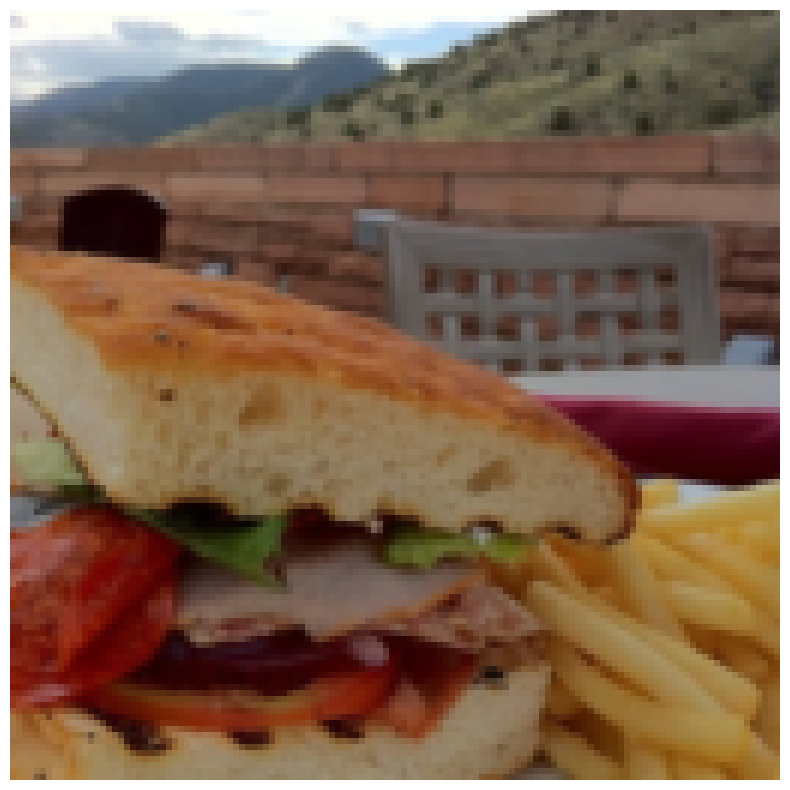

In [ ]:
index = random.randint(0, len(train_dataset) - 1)

image = train_dataset[index][0].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(10, 10))

plt.imshow(image)
plt.axis(False)
plt.show()

In [ ]:
def init_model(model):
    for par in model.parameters():
        if par.requires_grad:
            torch.nn.init.normal_(par, 0, 0.2)

    return model

In [ ]:
class ConvResBlock(torch.nn.Module):
    def __init__(self, channels, kernel=3, l=4):
        super().__init__()

        self.convs = torch.nn.ModuleList([self.__mini_conv_block(channels, kernel) for _ in range(l)])


    def __mini_conv_block(self, channels, kernel):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels, kernel, 1, padding="same", padding_mode="reflect"),
            torch.nn.BatchNorm2d(channels),
            torch.nn.LeakyReLU()
        )


    def forward(self, x):
        for conv in self.convs:
            x = conv(x) + x

        return x

In [ ]:
class DCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, classes, L=[4, 3, 2]):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.L = L
        self.classes = classes


        self.start = torch.nn.Sequential(
            torch.nn.Conv2d(self.in_channels, self.hidden_channels, 3, 1, padding="same", padding_mode="reflect"),
            torch.nn.BatchNorm2d(self.hidden_channels),
            torch.nn.LeakyReLU()
        )

        self.hidden = torch.nn.Sequential(*[torch.nn.Sequential(torch.nn.Conv2d(self.hidden_channels // (2 ** (i - 1)), self.hidden_channels // (2 ** i), 3, 1, padding="same", padding_mode="reflect"),
                                                                ConvResBlock(self.hidden_channels // (2 ** i), 3, l),
                                                                torch.nn.MaxPool2d(2, 2)) for i, l in enumerate(L, 1)])

        self.final = torch.nn.Sequential(
            torch.nn.Conv2d(self.hidden_channels // (2 ** (len(self.L))), self.classes, 4, 1),
            torch.nn.Flatten(),
            torch.nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.start(x)
        x = self.hidden(x)
        x = self.final(x)

        return x

In [ ]:
model = DCNN(3, 128, 101, L=[1, 1, 1, 1, 1]).to(device)

In [ ]:
model

DCNN(
  (start): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (hidden): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (1): ConvResBlock(
        (convs): ModuleList(
          (0): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (1): ConvResBlock(
     

In [ ]:
noice = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)

In [ ]:
%%time


model(noice).shape

CPU times: user 845 ms, sys: 590 ms, total: 1.44 s
Wall time: 1.63 s


torch.Size([8, 101])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

158213

In [ ]:
loss_f = torch.nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def train(model, train_data_load, loss_f, opti, epochs=5, per_vis=0.1):
    start_time = time.time()
    per_vis = int(1 / per_vis)

    history_train_loss = []
    history_train_acc = []


    for epoch in range(1, epochs + 1):
        model.train()

        total_train_loss = 0
        total_train_acc = 0

        for batch_i, (x, y) in enumerate(iter(train_data_load), 1):
            x, y = x.to(device), y.to(device)

            pred = model(x)

            loss = loss_f(pred, y)

            opti.zero_grad()
            loss.backward()
            opti.step()

            history_train_loss.append(loss.item())
            history_train_acc.append((pred.detach().argmax(dim=-1) == y).sum() / BATCH_SIZE)

            total_train_loss += loss.item()
            total_train_acc += (pred.detach().argmax(dim=-1) == y).sum() / BATCH_SIZE

            if batch_i % (len(train_data_load) // per_vis) == 0:
                total_train_loss /= len(train_data_load) // per_vis
                total_train_acc /= len(train_data_load) // per_vis


                end_time = time.time()
                work_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
                start_time = time.time()

                clear_output()

                print(f"[Epoch: {epoch}/{epochs}; batch: {batch_i}/{len(train_data_load)}; time: {work_time}; train_loss: {total_train_loss}; train_acc: {total_train_acc}]")
                torch.save(model, os.path.join(SAVE_DIR, f"modele{epoch}:{batch_i}.pt"))

                fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

                axis[0].plot(history_train_loss, c="blue")
                axis[0].set_title("Train loss")

                axis[1].plot(history_train_acc, c="orange")
                axis[1].set_title("Train acc")
                plt.show()

                total_train_loss = 0
                total_train_acc = 0

    return history_train_loss, history_train_acc

In [ ]:
def eval(model, val_data_load, loss_f):
    total_test_loss = 0
    total_test_acc = 0


    model.eval()
    for x, y in iter(val_data_load):
        with torch.inference_mode():
            pred = model(x)
            loss = loss_f(pred, y)

        total_test_loss += loss.item()
        total_test_acc += (pred.detach().argmax(dim=-1) == y).sum() / BATCH_SIZE

    total_test_loss /= len(val_data_load)
    total_test_acc /= len(val_data_load)

    model.train()

    return total_test_loss, total_test_acc

In [ ]:
model = torch.load(os.path.join(SAVE_DIR, "modele10:70.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/models/modele10:70.pt'

[Epoch: 1/10; batch: 432/9469; time: 00:00:30; train_loss: 4.611629062228733; train_acc: 0.013888888992369175]


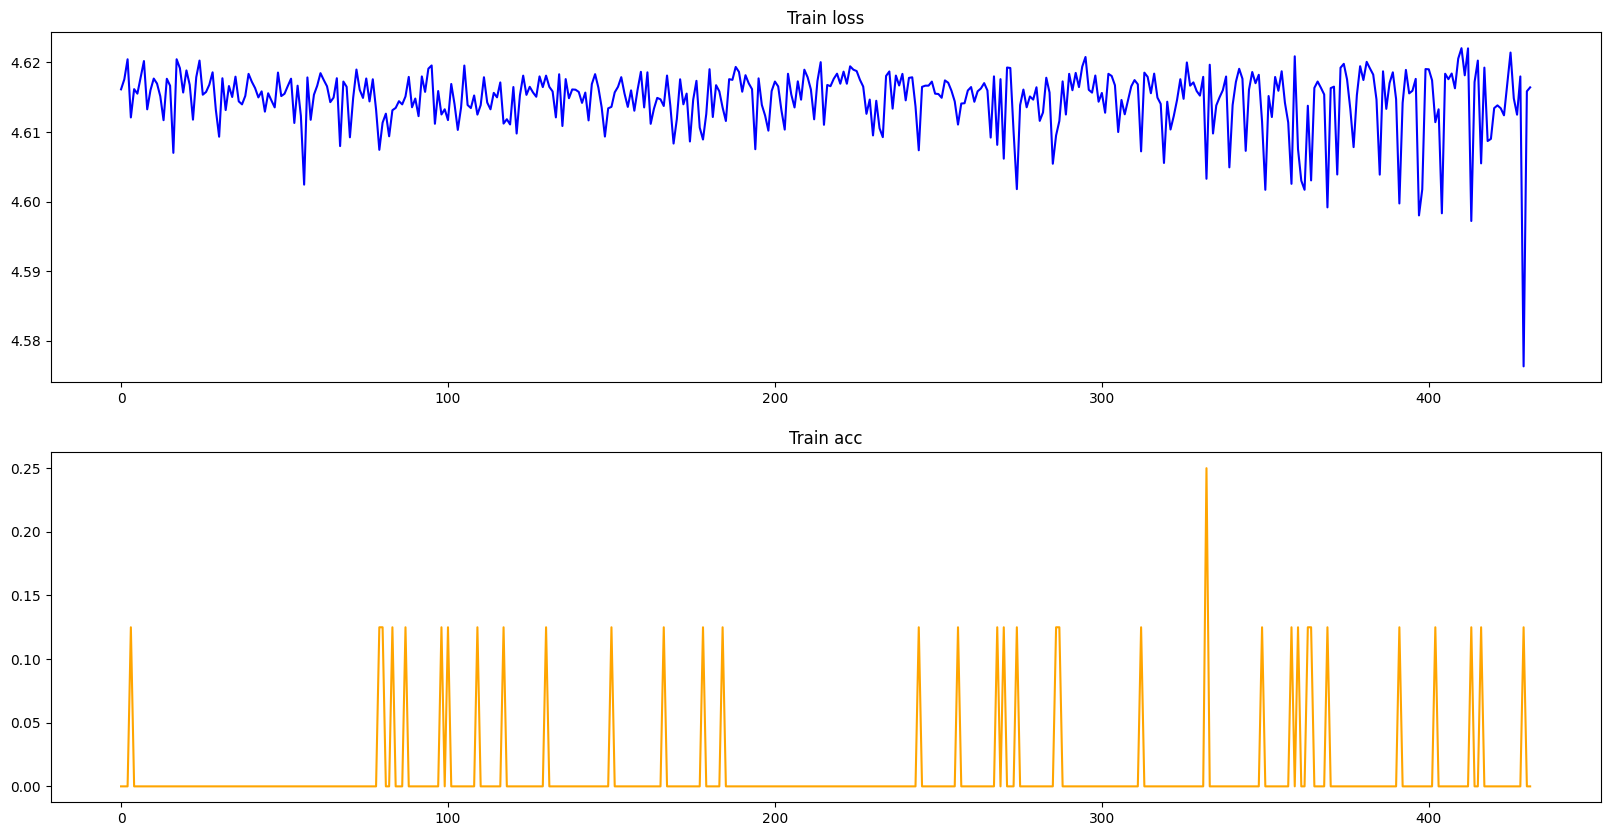

KeyboardInterrupt: 

In [36]:
history_train_loss, history_train_acc = train(model, train_data_load, loss_f, opti, epochs=10, per_vis=0.001)

In [ ]:
eval(model, val_data_load, loss_f)

(4.5230388259887695, tensor(0.1061))

In [ ]:
for index in range(len(train_dataset)):
  if train_dataset[index][0].shape[0] == 1:
    print(train_dataset[index][0].shape[0])
    print(index)

1
18508
1
23754
1
56094
